In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.ensemble
import sklearn.model_selection
import sklearn.metrics

import sys
# Our util file is in the parent directory
sys.path.append('../')
import utils as mutil

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

## Load the data

In [2]:
titanic_train = pd.read_csv("titanic/train.csv")
titanic_train_ids = titanic_train['PassengerId']
titanic_test = pd.read_csv("titanic/test.csv")
titanic_test_ids = titanic_test['PassengerId']

titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Data exploration
display(titanic_train.groupby('Embarked')['Embarked'].count())
print(titanic_train['Embarked'].count(), '/', titanic_train['PassengerId'].count())

print(titanic_train['Age'].count(), '/', titanic_train['PassengerId'].count())

titanic_test.describe(include='all')

Embarked
C    168
Q     77
S    644
Name: Embarked, dtype: int64

889 / 891
714 / 891


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


## Preprocess the data to increase the usability for our ML techniques
__Transformations:__
* The Cabin feature is not usable in its current form but it contains the information if the person had a cabin or not, so we can extract that information
    * Cabin => yes (1) | no (0)
* The sibling (SibSp) and parent (Parch) features are very simillar and can be combined into a family size parameter to describe the circumstances more concise and therfore make it easier for our model to learn
    * SibSp + Parch => Family size
* The embarked column has 2 missing entries, we can fill those with the most common option 'S'
<!--     * Then we can map it into a numerical value to make it more interoperable with numeric ML techniques -->
* Age has many missing values so we will replace the missing values with the mean of the column
    * Another option would be to replace missing values with random values using the standard deviation curve arround the mean and variance of the Age column
* In the test data the Fare column has missing values as well, we also fill these with the mean of that column

### Sources:
* https://www.kaggle.com/code/sinakhorami/titanic-best-working-classifier
* https://www.kaggle.com/code/dmilla/introduction-to-decision-trees-titanic-dataset/notebook

In [4]:
def replace_random(df, c):
    avg = df[c].mean()
    std = df[c].std()
    null_count = df[c].isnull().sum()
    
    null_random_list = np.random.randint(avg - std, avg + std, size=null_count)
    df.loc[np.isnan(df[c]), c] = null_random_list
    return

def preprocess(orig_df: pd.DataFrame):
    df = orig_df.copy()
    embarked_map = {'S': 0, 'C': 1, 'Q': 2}
    drop_columns = ['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin']
    df['Had Cabin'] = df['Cabin'].map(lambda c: 0 if type(c) != str else 1)
    df['Family size'] = df['SibSp'] + df['Parch']
    df['Embarked'] = df['Embarked'].fillna('S').map(lambda c: embarked_map[c])
    df['Sex'] = df['Sex'].map(lambda c: 0 if c == 'male' else 1)
    # df['Age'] = df['Age'].fillna(df['Age'].mean())
    replace_random(df, 'Age')
    # df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
    replace_random(df, 'Fare')

    # Drop all unused columns
    df = df.drop(columns=drop_columns)
    return df
    
titanic_train_clean = preprocess(titanic_train)
#titanic_train[['SibSp', 'Parch', 'Family size']]

In [5]:
# Print expected influence of the features on our prediction models
printmd("### Print expected influence of the features on our prediction models")

print(titanic_train_clean[['Had Cabin', 'Survived']].groupby(['Had Cabin']).mean())
# It looks like passangers without a cabin had worse chances of surviving

print(titanic_train_clean[['Family size', 'Survived']].groupby(['Family size']).mean())
# Very varying mean accross the family size so we expect it to have a significant impact onto our dataset

print(titanic_train_clean[['Embarked', 'Survived']].groupby(['Embarked']).mean())
# Should also have a significant effect due to varying means accross classes

### Print expected influence of the features on our prediction models

           Survived
Had Cabin          
0          0.299854
1          0.666667
             Survived
Family size          
0            0.303538
1            0.552795
2            0.578431
3            0.724138
4            0.200000
5            0.136364
6            0.333333
7            0.000000
10           0.000000
          Survived
Embarked          
0         0.339009
1         0.553571
2         0.389610


In [6]:
titanic_train_clean.describe(include='all')

,Survived,Pclass,Sex,Age,Fare,Embarked,Had Cabin,Family size
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.607374,32.204208,0.361392,0.228956,0.904602
std,0.486592,0.836071,0.477990,13.490110,49.693429,0.635673,0.420397,1.613459
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,21.000000,7.910400,0.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,28.500000,14.454200,0.000000,0.000000,0.000000
75%,1.000000,3.000000,1.000000,37.000000,31.000000,1.000000,0.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,512.329200,2.000000,1.000000,10.000000


In [7]:
titanic_train_clean.groupby("Survived")['Survived'].count()

Survived
0    549
1    342
Name: Survived, dtype: int64

In [8]:
train_x = titanic_train_clean.drop(columns=['Survived'])
train_y = titanic_train_clean['Survived']

## Search for the best descision tree configuration

In [9]:
from sklearn.model_selection import GridSearchCV

# Number of trees in random forest
n_estimators = [20, 50, 100, 300, 700, 900, 1200]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [2, 5, 10]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               # Fixed parameters
               'criterion':['gini'], 'class_weight': ['balanced']
              }
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = sklearn.ensemble.RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = GridSearchCV(rf, random_grid, cv=3, n_jobs=6, verbose=10)
rf_random.fit(train_x, train_y)


{'n_estimators': [20, 50, 100, 300, 700, 900, 1200], 'max_features': ['sqrt'], 'max_depth': [2, 5, 10, None], 'min_samples_split': [5, 10, 20], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True], 'criterion': ['gini'], 'class_weight': ['balanced']}
Fitting 3 folds for each of 252 candidates, totalling 756 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=6,
             param_grid={'bootstrap': [True], 'class_weight': ['balanced'],
                         'criterion': ['gini'], 'max_depth': [2, 5, 10, None],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [5, 10, 20],
                         'n_estimators': [20, 50, 100, 300, 700, 900, 1200]},
             verbose=10)

In [10]:
rf_random.best_params_

{'bootstrap': True,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 300}

## Train our model based on this configuration estimation

In [11]:
# Create training dataset
train_x = titanic_train_clean.drop(columns=['Survived'])
train_y = titanic_train_clean['Survived']
# Train model based on best estimated configuration from previous tests
model = sklearn.ensemble.RandomForestClassifier(max_depth= 10, n_estimators=300,  min_samples_leaf=1,  min_samples_split=5, max_features='sqrt',
                                                bootstrap=True, criterion='gini',class_weight="balanced")
model = model.fit(X=train_x, y=train_y)
# Calculate train accuracy
train_accuracy = model.score(X=train_x, y=train_y)
print(f"Train accuracy {train_accuracy}")
print(f"Training set utilisation = {100 * len(titanic_train_clean) / len(titanic_train)}%")

# Create test dataset
titanic_test_clean = preprocess(titanic_test)
# Calculate test accuracy
predictions = model.predict(X=titanic_test_clean)
submission_df = pd.DataFrame(data={'PassengerId': titanic_test['PassengerId'], 'Survived': predictions})
submission_df = submission_df.set_index('PassengerId')
submission_df

Train accuracy 0.9292929292929293
Training set utilisation = 100.0%


,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [12]:
submission_df.to_csv("Titanic_prediction-RandomForest.csv")

## Evaluaton based on titanic test-set

In [13]:
titanic_test_with_labels = pd.read_csv("../../project/test-set-solution.csv")
titanic_test_with_labels = titanic_test_with_labels.drop(columns=["boat", "body", "home.dest"])
titanic_test_with_labels["PassengerId"] = [titanic_train.shape[0] + i for i in range(titanic_test_with_labels.shape[0])]
titanic_test_with_labels.head()

,Pclass,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PassengerId
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,891
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,892
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,893
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,894
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,895


Is there an onverlap with the training dataset?

In [14]:
merge = titanic_test_with_labels.merge(titanic_train, on=["Name"], how='left', indicator=True)
merge["duplicate"] = merge["_merge"] == "both"
merge.groupby("duplicate")["duplicate"].count()

duplicate
False    416
True     893
Name: duplicate, dtype: int64

Yes, so we need to clean that up

In [15]:
titanic_test_with_labels_u = titanic_test_with_labels.merge(titanic_train, on=["Name"], how='outer', indicator=True).query('_merge=="left_only"').drop("_merge", axis=1)
titanic_test_with_labels_u = titanic_test_with_labels_u.drop(columns=["PassengerId_y", "Survived_y", "Pclass_y", "Age_y", "SibSp_y", "Parch_y", "Ticket_y", "Embarked_y", "Sex_y", "Fare_y", "Cabin_y"])
titanic_test_with_labels_u.rename(columns={
    "Pclass_x": "Pclass",
    "Survived_x": "Survived",
    "Sex_x": "Sex",
    "Age_x": "Age",
    "SibSp_x": "SibSp", 
    "Parch_x": "Parch",
    "Ticket_x": "Ticket",
    "Fare_x": "Fare",
    "Cabin_x": "Cabin",
    "Embarked_x": "Embarked",
    "PassengerId_x": "PassengerId",}, inplace=True)
titanic_test_with_labels_u

,Pclass,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PassengerId
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0,1,2,113781,151.5500,C22 C26,S,894
10,1,0,"Astor, Col. John Jacob",male,47.0,1,0,PC 17757,227.5250,C62 C64,C,901
19,1,0,"Beattie, Mr. Thomson",male,36.0,0,0,13050,75.2417,C6,C,910
24,1,1,"Bird, Miss. Ellen",female,29.0,0,0,PC 17483,221.7792,C97,S,915
25,1,0,"Birnbaum, Mr. Jakob",male,25.0,0,0,13905,26.0000,NaN,C,916
...,...,...,...,...,...,...,...,...,...,...,...,...
1291,3,0,"Willer, Mr. Aaron (""Abi Weller"")",male,NaN,0,0,3410,8.7125,NaN,S,2182
1296,3,0,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,2187
1298,3,0,"Wittevrongel, Mr. Camille",male,36.0,0,0,345771,9.5000,NaN,S,2189
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5,0,0,2656,7.2250,NaN,C,2197


### Now lets test our accuracy against the test set

In [16]:
# Create test dataset
titanic_test_with_labels_clean = preprocess(titanic_test_with_labels_u)
test_x = titanic_test_with_labels_clean.drop(columns=['Survived'])
test_y = titanic_test_with_labels_clean['Survived']
# Calculate test accuracy
titianic_test_score = model.score(X=test_x, y=test_y)
print(f"Test score = {titianic_test_score}")
print(f"Missing classifications = {len(titanic_test_with_labels_u) - len(titanic_test_with_labels_clean)}")

Test score = 0.7596153846153846
Missing classifications = 0


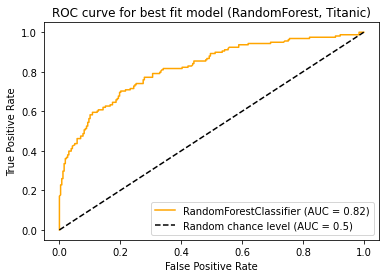

In [17]:
mutil.plot_roc(model, test_x, test_y, "ROC curve for best fit model (RandomForest, Titanic)")

In [18]:
f1 = mutil.calc_f1(model, test_x, test_y)
print(f"Weighted F1-score = {f1}")

Weighted F1-score = 0.759903636729861


In [19]:
pred_y = model.predict(test_x)
print(sklearn.metrics.classification_report(y_true=test_y, y_pred=pred_y))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81       258
           1       0.68      0.69      0.69       158

    accuracy                           0.76       416
   macro avg       0.74      0.75      0.75       416
weighted avg       0.76      0.76      0.76       416



In [20]:
sklearn.metrics.confusion_matrix(test_y, pred_y)

array([[207,  51],
       [ 49, 109]], dtype=int64)

## Test some different model parameters
With a simpler model to combar the overfitting

In [21]:
# Train model
model = sklearn.ensemble.RandomForestClassifier(min_samples_split= 10, n_estimators= 90, criterion='gini', min_samples_leaf= 1, class_weight="balanced")
model = model.fit(X=train_x, y=train_y)

# Calculate train accuracy
train_accuracy = model.score(X=train_x, y=train_y)
print(f"Train accuracy {train_accuracy}")
print(f"Training set utilisation = {100 * len(titanic_train_clean) / len(titanic_train)}%\n")

# Create test dataset
titanic_test_with_labels_clean = preprocess(titanic_test_with_labels_u)
test_x = titanic_test_with_labels_clean.drop(columns=['Survived'])
test_y = titanic_test_with_labels_clean['Survived']
# Calculate test accuracy
titianic_test_score = model.score(X=test_x, y=test_y)
print(f"Test score = {titianic_test_score}")
print(f"Missing classifications = {len(titanic_test_with_labels_u) - len(titanic_test_with_labels_clean)}")

Train accuracy 0.9046015712682379
Training set utilisation = 100.0%

Test score = 0.7644230769230769
Missing classifications = 0


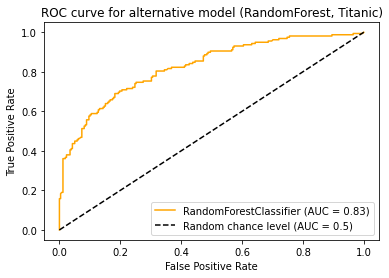

In [22]:
mutil.plot_roc(model, test_x, test_y, "ROC curve for alternative model (RandomForest, Titanic)")

In [23]:
f1 = mutil.calc_f1(model, test_x, test_y)
print(f"Weighted F1-score = {f1}")

Weighted F1-score = 0.7649752103365385


In [24]:
pred_y = model.predict(test_x)
print(sklearn.metrics.classification_report(y_true=test_y, y_pred=pred_y))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81       258
           1       0.69      0.70      0.69       158

    accuracy                           0.76       416
   macro avg       0.75      0.75      0.75       416
weighted avg       0.77      0.76      0.76       416



In [25]:
sklearn.metrics.confusion_matrix(test_y, pred_y)

array([[207,  51],
       [ 47, 111]], dtype=int64)

In [31]:
train_x.iloc(0)[0]

Pclass          3.00
Sex             0.00
Age            22.00
Fare            7.25
Embarked        0.00
Had Cabin       0.00
Family size     1.00
Name: 0, dtype: float64

In [32]:
train_y[0]

0